In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
from numpy.polynomial.chebyshev import Chebyshev
from scipy.stats import beta
#%matplotlib notebook
random_seed = 0
np.random.seed(seed=random_seed)
torch.manual_seed(random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
class BayesNetwork(nn.Module):
    def __init__(self, input_size, random_features, hidden_sizes, output_):
        super(BayesNetwork, self).__init__()
        #distribution = dist.Uniform(0, 1)
        self.theta_true = nn.Linear(100,1, bias=False)
        self.model = FHatNetwork(random_features,hidden_sizes,output_size)
    def forward(self, x):
        final_x = x*self.theta_true.weight
        return self.model(final_x)
    
# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim):
        super(HyperNetwork, self).__init__()
        self.input_dim = input_dim
        self.hyper_layer = FHatNetwork(1,[],input_dim)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        return x@self.hyper_layer(alpha)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        elif self.name == 'quantile':
            return self.quantile(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
   
    def quantile(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        return var
    
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def compute_cvar_h(self, alpha, h, env_dict):
        loss_fn = torch.nn.MSELoss()        
        risks = []
        for e in env_dict.keys():
            output = h(env_dict[e]['x'].to(self.device), alpha.to(self.device))
            risks.append(loss_fn(output,env_dict[e]['y'].to(self.device)))
        risks = torch.stack(risks)
        cvar = self.aggregator.aggregate(risks, alpha)
        return cvar
    
    def fit_h(self, h, env_dict, 
              dist=None, optimizer=None, scheduler=None, alphas=None, num_epochs=100):
        loss_fn = torch.nn.MSELoss()
        if dist is not None:
            if dist == "beta_2_2":
                alphas = np.random.beta(a=2, b=2, size=10)
            elif dist == "beta_05_05":
                alphas = np.random.beta(a=0.5, b=0.5, size=10)  
            elif dist == "beta_5_1":
                alphas = np.random.beta(a=2, b=1, size=10) 
            elif dist == "beta_1_5":
                alphas = np.random.beta(a=1, b=2, size=10) 
            else:
                alphas = np.random.beta(a=1, b=1, size=10) 
        
        print(alphas)
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        
        if optimizer is None:
            learning_rate = 0.03
            optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        if scheduler is None:
            scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
        for epoch in range(num_epochs):
            if len(alphas) == 1:
                risks = []
                for e in env_dict.keys():
                    output = h(env_dict[e]['x'].to(self.device), alphas.to(self.device))
                    risks.append(loss_fn(output,env_dict[e]['y'].to(self.device)))
                risks = torch.stack(risks)
                avg_cvar = self.aggregator.aggregate(risks, alphas)
                avg_cvar.backward()
            else:   
                avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
                avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = []
            for e in env_dict.keys():
                x, y = env_dict[e]['x'].to(self.device), env_dict[e]['y'].to(self.device) 
                #alpha_column = torch.full((1000, 1), data_dict_test[e]['theta_true'].item()).to(device)
                #finalx = torch.cat((x, y), dim=1)
                risks.append(loss_fn(f(x),y))
            risks = torch.stack(risks)
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_dict_train, env_dict_test = {}, {}
        #env_thetas_train = {i: theta for i, theta in enumerate(np.linspace(0,1, self.envs_train))}
        #env_thetas_test = {i: theta for i, theta in enumerate(np.linspace(0,1, self.envs_test))}
        for e_train in range(self.envs_train):
            if self.theta_dist == "uniform":
                #theta_true = torch.tensor([env_thetas_train[e_train]]).unsqueeze(1).float()
                distribution = dist.Uniform(0, 1)
                theta_true = distribution.sample((self.dim,1))
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
                theta_true = distribution.sample((self.dim,1))
            else:
                distribution1 = dist.Uniform(-1.5, -1.0)
                distribution2 = dist.Uniform(1.0, 1.5)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
                theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=2.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in range(self.envs_test):
            if self.theta_dist == "uniform": 
                #theta_true = torch.tensor([env_thetas_train[e_train]]).unsqueeze(1).float()
                distribution = dist.Uniform(0, 1)
                theta_true = distribution.sample((self.dim,1))
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
                theta_true = distribution.sample((self.dim,1))
            else:
                distribution1 = dist.Uniform(-1.5, -1.0)
                distribution2 = dist.Uniform(1.0, 1.5)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
                theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=2.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

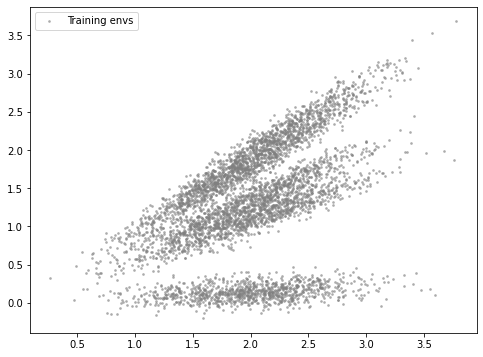

In [9]:
# Intitialize the experiment and generate the data
dim = 1
envs_train, envs_test = 5, 250
size_train, size_test = 1000 , 1000
theta_dist="uniform" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.5, label="Training envs")
ax.legend(loc='upper left')
fig.savefig("env.pdf", format='pdf', bbox_inches='tight')

In [10]:
import copy
def fixed(data_dict_train, dim, alphas):
    f = BayesNetwork(1,10,[100],dim).to(device)
    groundtruths = []
    for alpha in alphas:
        ARM_Regression(name=rho).fit_f(f, data_dict_train, alpha)
        groundtruths.append(copy.deepcopy(f))
    print("GT Trained")    
    h_2_2 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_2_2, data_dict_train, "beta_2_2")
    print("Beta 2 2 Trained")  
    h_05_05 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_05_05, data_dict_train, "beta_05_05")
    print("Beta 05 05 Trained")    
    h_5_1 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_5_1, data_dict_train, "beta_5_1")
    print("Beta 5 1 Trained")
    h_1_5 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_1_5, data_dict_train, "beta_1_5")
    print("Beta 1 5 Trained")
    h_1_1 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_1_1, data_dict_train, "beta_1_1")
    print("Beta 1 1 Trained")
    
        
    return groundtruths, h_2_2, h_05_05, h_5_1, h_1_5, h_1_1

In [11]:
def execute(true_alpha, ground_truth_f, h_2_2, h_05_05, h_5_1, h_1_5, h_1_1, data_dict_test):
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            #alpha_column = torch.full((1000, 1), data_dict_test[e]['theta_true'].item()).to(device)
            #finalx = torch.cat((x, alpha_column), dim=1)
            train_risks.append(loss_fn(ground_truth_f(x).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    gt_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)

    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(h_2_2(x,torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    beta22cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(h_05_05(x,torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    beta0505cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(h_5_1(x,torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    beta51cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(h_1_5(x,torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    beta15cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(h_1_1(x,torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    beta11cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    return gt_cvar.item(), beta22cvar.item(), beta0505cvar.item(), beta51cvar.item(), beta15cvar.item(), beta11cvar.item()

In [12]:
# New function to reset seeds and reinitialize models
def reinitialize_models(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return fixed(data_dict_train, dim, true_alphas)

# Main loop for iterating over different seeds
num_seeds = [0,1,2,3,4,5,6,7,8,9]  # Number of different seeds to use
true_alphas = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
results = {str(true_alpha): {"GT": [], "Beta_2_2": [], "Beta_05_05": [], "Beta_5_1": [],"Beta_1_5": [], "Beta_1_1": []} for true_alpha in true_alphas}

for seed in num_seeds:
    # Reinitialize models with the new seed
    ground_truths,h_2_2, h_05_05, h_5_1,h_1_5, h_1_1= reinitialize_models(seed)
    
    for index in range(len(true_alphas)):
        ground_truth, beta_2_2, beta_05_05, beta_5_1, beta_1_5, beta_1_1 = execute(true_alphas[index], ground_truths[index], h_2_2, h_05_05, h_5_1, h_1_5, h_1_1, data_dict_test)    
        # Collecting the results
        results[str(true_alphas[index])]["GT"].append(ground_truth)
        results[str(true_alphas[index])]["Beta_2_2"].append(beta_2_2)
        results[str(true_alphas[index])]["Beta_05_05"].append(beta_05_05)
        results[str(true_alphas[index])]["Beta_5_1"].append(beta_5_1)
        results[str(true_alphas[index])]["Beta_1_5"].append(beta_5_1)
        results[str(true_alphas[index])]["Beta_1_1"].append(beta_1_1)

Epoch [100/100], Loss: 0.5615025758743286
Epoch [100/100], Loss: 0.5618817806243896
Epoch [100/100], Loss: 0.5622848868370056
Epoch [100/100], Loss: 0.5629768967628479
Epoch [100/100], Loss: 0.7358705401420593
Epoch [100/100], Loss: 0.8527048826217651
Epoch [100/100], Loss: 0.99423748254776
Epoch [100/100], Loss: 1.003269910812378
Epoch [100/100], Loss: 1.0031967163085938
Epoch [100/100], Loss: 1.0092518329620361
Epoch [100/100], Loss: 1.0262404680252075
Epoch [100/100], Loss: 1.0262532234191895
GT Trained
[0.69657222 0.88624781 0.40532375 0.60954516 0.51938284 0.75805501
 0.02419695 0.94247139 0.5088501  0.79702417]
Epoch [10/100], Loss: 1.2566839456558228
Epoch [20/100], Loss: 1.2954617738723755
Epoch [30/100], Loss: 1.093673825263977
Epoch [40/100], Loss: 1.0994073152542114
Epoch [50/100], Loss: 1.0777853727340698
Epoch [60/100], Loss: 1.0661611557006836
Epoch [70/100], Loss: 1.0609896183013916
Epoch [80/100], Loss: 1.0559144020080566
Epoch [90/100], Loss: 1.052080750465393
Epoch [1

Epoch [40/100], Loss: 1.361965537071228
Epoch [50/100], Loss: 1.349934458732605
Epoch [60/100], Loss: 1.3445583581924438
Epoch [70/100], Loss: 1.3393001556396484
Epoch [80/100], Loss: 1.3334813117980957
Epoch [90/100], Loss: 1.328376054763794
Epoch [100/100], Loss: 1.3235749006271362
Beta 5 1 Trained
[0.08327334 0.47815036 0.80562169 0.31124801 0.17222357 0.24132719
 0.31250884 0.59542816 0.14739803 0.00624835]
Epoch [10/100], Loss: 0.9657368063926697
Epoch [20/100], Loss: 0.9141641855239868
Epoch [30/100], Loss: 0.9049720764160156
Epoch [40/100], Loss: 0.8940054178237915
Epoch [50/100], Loss: 0.8879518508911133
Epoch [60/100], Loss: 0.8824713826179504
Epoch [70/100], Loss: 0.8809887766838074
Epoch [80/100], Loss: 0.8811019062995911
Epoch [90/100], Loss: 0.8803038597106934
Epoch [100/100], Loss: 0.8803971409797668
Beta 1 5 Trained
[0.61180825 0.25139057 0.42939523 0.17391624 0.79936509 0.96235837
 0.24574358 0.74110057 0.37715551 0.44299198]
Epoch [10/100], Loss: 11.165312767028809
Epo

Epoch [100/100], Loss: 1.0434060096740723
Epoch [100/100], Loss: 1.0247653722763062
GT Trained
[0.64372593 0.84067723 0.42423923 0.2806314  0.252123   0.12500997
 0.39685294 0.54495116 0.52142258 0.74892803]
Epoch [10/100], Loss: 1.0477499961853027
Epoch [20/100], Loss: 1.1014389991760254
Epoch [30/100], Loss: 1.0016435384750366
Epoch [40/100], Loss: 0.9958576560020447
Epoch [50/100], Loss: 0.9997744560241699
Epoch [60/100], Loss: 0.9949529767036438
Epoch [70/100], Loss: 0.9946519732475281
Epoch [80/100], Loss: 0.9937936663627625
Epoch [90/100], Loss: 0.9944888353347778
Epoch [100/100], Loss: 0.9937345385551453
Beta 2 2 Trained
[2.22422782e-05 6.89194008e-01 7.16463141e-01 1.01687671e-01
 1.64428860e-01 6.75456313e-01 9.87123732e-01 9.90419986e-01
 3.20166491e-01 6.84509541e-02]
Epoch [10/100], Loss: 1.4208612442016602
Epoch [20/100], Loss: 1.3370975255966187
Epoch [30/100], Loss: 1.184127688407898
Epoch [40/100], Loss: 1.0875271558761597
Epoch [50/100], Loss: 1.0413795709609985
Epoch 

Epoch [20/100], Loss: 0.8917050361633301
Epoch [30/100], Loss: 0.8894577026367188
Epoch [40/100], Loss: 0.8840999603271484
Epoch [50/100], Loss: 0.8807859420776367
Epoch [60/100], Loss: 0.8788877725601196
Epoch [70/100], Loss: 0.8772880434989929
Epoch [80/100], Loss: 0.8762073516845703
Epoch [90/100], Loss: 0.8754008412361145
Epoch [100/100], Loss: 0.8748043179512024
Beta 1 5 Trained
[0.20195195 0.82257373 0.84492118 0.85038462 0.86570063 0.76039046
 0.35950538 0.95804668 0.97333829 0.4948759 ]
Epoch [10/100], Loss: 1.091280221939087
Epoch [20/100], Loss: 1.0773580074310303
Epoch [30/100], Loss: 1.0666840076446533
Epoch [40/100], Loss: 1.0598822832107544
Epoch [50/100], Loss: 1.053615927696228
Epoch [60/100], Loss: 1.0423932075500488
Epoch [70/100], Loss: 1.0371507406234741
Epoch [80/100], Loss: 1.032639741897583
Epoch [90/100], Loss: 1.0289958715438843
Epoch [100/100], Loss: 1.0265034437179565
Beta 1 1 Trained
Epoch [100/100], Loss: 0.5616046190261841
Epoch [100/100], Loss: 0.56348997

In [13]:
def compute_statistics(results):
    means = {}
    std_devs = {}

    for key, value in results.items():
        # Ensure value is a list of numbers, not a dictionary
        if isinstance(value, dict):
            means[key] = {sub_key: np.mean(sub_value) for sub_key, sub_value in value.items()}
            std_devs[key] = {sub_key: np.std(sub_value) for sub_key, sub_value in value.items()}
        else:
            means[key] = np.mean(value)
            std_devs[key] = np.std(value)

    return means, std_devs
means, std_devs = compute_statistics(results)

In [14]:
print("GT")
for key in results.keys():
    print(round(means[key]['GT'],4),std_devs[key]['GT'])

print("Beta_2_2")
for key in results.keys():
    print(round(means[key]['Beta_2_2'],4),std_devs[key]['Beta_2_2'])
    
print("Beta_05_05")
for key in results.keys():
    print(round(means[key]['Beta_05_05'],4),std_devs[key]['Beta_05_05'])
print("Beta_5_1")
for key in results.keys():
    print(round(means[key]['Beta_5_1'],4),std_devs[key]['Beta_5_1'])
print("Beta_1_5")
for key in results.keys():
    print(round(means[key]['Beta_1_5'],4),std_devs[key]['Beta_1_5'])
print("Beta_1_1")
for key in results.keys():
    print(round(means[key]['Beta_1_1'],4),std_devs[key]['Beta_1_1'])

GT
0.4285 0.0098606667996213
0.4716 0.014754419721072642
0.4896 0.025077134833269694
0.5269 0.00852878588823471
0.6307 0.006990987257726788
0.7197 0.014035308525946637
0.666 0.04289423790634473
0.753 0.045508587439755804
0.8099 0.024804229335152174
0.9377 0.03440994292231093
1.0738 0.025685882546870934
1.2646 0.02910489232620488
Beta_2_2
0.8688 0.4127782995842602
0.8075 0.3024090369227179
0.7871 0.25699550720114583
0.7688 0.21598454823756355
0.7545 0.15220632404275064
0.7738 0.10206485897650235
0.835 0.06132379116089621
0.9582 0.14276569278037837
1.1736 0.3997070484904346
1.4773 0.7403996902842558
1.9211 1.127465403530602
2.4938 1.6048593970451064
Beta_05_05
0.599 0.08209309044841222
0.6239 0.07476336093017719
0.6413 0.07086275102828367
0.659 0.06615770038010442
0.7049 0.055479863938913965
0.7634 0.04532602025700421
0.8326 0.044134652231929784
0.9137 0.06961707953049338
1.0126 0.14659224679638141
1.1267 0.26088780167647435
1.2876 0.3863935096655945
1.536 0.5371964343473388
Beta_5_1
0.8

In [15]:
data={}
for learner in ["GT", "Beta_2_2", "Beta_05_05", "Beta_5_1","Beta_1_5", "Beta_1_1"]:
    data[learner]={"mean":[], "std":[]}
    for key in results.keys():
        data[learner]["mean"].append(means[key][learner])
        data[learner]["std"].append(std_devs[key][learner]) 
#data["GT"]["mean"].sort()
data["GT"]["mean"]=[item-0.1 for item in data["GT"]["mean"]]
#data["Beta_5_1"]["std"]=[item/5 for item in data["Beta_5_1"]["std"]]
#data["Beta_1_5"]["std"]=[item/5 for item in data["Beta_1_5"]["std"]]

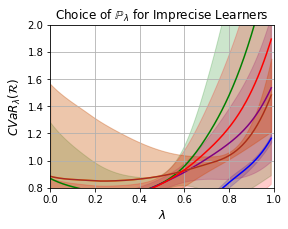

In [16]:
from scipy.interpolate import make_interp_spline
# Different color for each learner
custom_legend_names = {
    "GT": "GT ($\lambda$ known)",
    "Beta_2_2":"$a=2,b=2$",
    "Beta_05_05":"$a=0.5,b=0.5$", 
    "Beta_5_1":"$a=5,b=1$", 
    "Beta_1_5":"$a=1,b=5$", 
    "Beta_1_1":"$a=1,b=1$"
}

colors = {
    "GT": "blue", 
    "Beta_2_2": "green",
    "Beta_05_05": "purple", 
    "Beta_5_1": "orange", 
    "Beta_1_5": "brown", 
    "Beta_1_1": "red"
}
lambdas = np.array(true_alphas)
# Create the plot
plt.figure(figsize=(4, 3))
for learner, color in colors.items():
    xnew = np.linspace(lambdas.min(), lambdas.max(), 300)  

    # Smooth the mean
    mean_spline = make_interp_spline(lambdas, data[learner]["mean"], k=3)
    mean_smooth = mean_spline(xnew)
    plt.plot(xnew, mean_smooth, label=custom_legend_names[learner], color=color)

    # Smooth the standard deviation
    std_spline_up = make_interp_spline(lambdas, np.array(data[learner]["mean"])+np.array(data[learner]["std"]), k=3)
    std_spline_dow = make_interp_spline(lambdas, np.array(data[learner]["mean"])-np.array(data[learner]["std"]), k=3)
    std_smooth_up, std_smooth_dow = std_spline_up(xnew), std_spline_dow(xnew)
    plt.fill_between(xnew, 
                     std_smooth_up, 
                     std_smooth_dow, 
                     color=color, alpha=0.2)

# Limit y-axis to exclude outlier values
plt.ylim(0.8,2.0)  # Set y-axis limit
plt.xlim(0,1)
# Labels and title
plt.xlabel('$\lambda$', fontsize='large')
plt.ylabel('$CVaR_\lambda(\mathbf{\mathcal{R}})$',fontsize='large')
plt.title('Choice of $\mathbb{P}_\lambda$ for Imprecise Learners')
#plt.legend(fontsize='small')
plt.grid(True)
#plt.savefig('beta_ablation.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

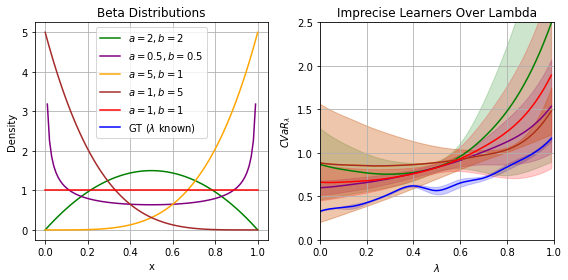

In [17]:
# Different color for each learner
custom_legend_names = {
    "GT": "GT ($\lambda$ known)",
    "Beta_2_2":"$a=2,b=2$",
    "Beta_05_05":"$a=0.5,b=0.5$", 
    "Beta_5_1":"$a=5,b=1$",
    "Beta_1_5":"$a=1,b=5$",
    "Beta_1_1":"$a=1,b=1$"
}

colors = {
    "GT": "blue", 
    "Beta_2_2": "green",
    "Beta_05_05": "purple", 
    "Beta_5_1": "orange", 
    "Beta_1_5": "brown",
    "Beta_1_1": "red"
}
lambdas = np.array(true_alphas)
beta_params = {
    "Beta_2_2": (2, 2),
    "Beta_05_05": (0.5, 0.5),
    "Beta_5_1": (5, 1),
    "Beta_1_5": (1, 5),
    "Beta_1_1": (1, 1)
}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plotting Beta distributions on the left plot
for learner, (a, b) in beta_params.items():
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a, b)
    ax1.plot(x, y, color=colors[learner], label=custom_legend_names[learner])
ax1.plot([], [], color=colors["GT"], label=custom_legend_names["GT"])
ax1.set_title('Beta Distributions')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.grid(True)
ax1.legend()
# Plotting data on the right plot
for learner, color in colors.items():
    if learner in data:
        xnew = np.linspace(lambdas.min(), lambdas.max(), 300) 
        mean_spline = make_interp_spline(lambdas, data[learner]["mean"], k=3)
        mean_smooth = mean_spline(xnew)
        ax2.plot(xnew, mean_smooth, color=color, label=custom_legend_names[learner])

        std_spline_up = make_interp_spline(lambdas, np.array(data[learner]["mean"]) + np.array(data[learner]["std"]), k=3)
        std_spline_down = make_interp_spline(lambdas, np.array(data[learner]["mean"]) - np.array(data[learner]["std"]), k=3)
        std_smooth_up, std_smooth_down = std_spline_up(xnew), std_spline_down(xnew)
        ax2.fill_between(xnew, std_smooth_up, std_smooth_down, color=color, alpha=0.2)

ax2.set_ylim(0, 2.5)
ax2.set_xlim(0, 1)
ax2.set_title('Imprecise Learners Over Lambda')
ax2.set_xlabel('$\lambda$')
ax2.set_ylabel('$CVaR_\lambda$')
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
fig.savefig('beta_ablation.pdf', format='pdf', bbox_inches='tight')

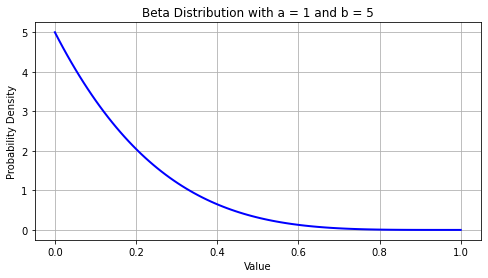

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Parameters for the beta distribution
a, b = 1, 5

# Generating values
x = np.linspace(0, 1, 100)
y = beta.pdf(x, a, b)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x, y, 'b-', lw=2)
plt.title(f'Beta Distribution with a = {a} and b = {b}')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [19]:
data["GT"]["mean"]

[0.3284599632024765,
 0.3715837687253952,
 0.3896491289138794,
 0.4268987894058228,
 0.5306714415550232,
 0.6197279512882233,
 0.5659700214862824,
 0.6530393958091736,
 0.7099417507648468,
 0.8376525521278382,
 0.9737753868103028,
 1.1646217226982116]